# Observational setup

Here, we set up the observations of the eromapper cluster member galaxies at the AAT.

For each observation (which corresponds to one cluster), we need to produce a single `.fdl` file in the correct format.\
This file needs to include:

- The galaxies to observe (`members`) as the science targets (` = P`)
- The guide stars (` = F`)
- The sky fibres (` = S`),

Where the letter needs to provided with the sources.

## Preparation steps

For each of the clusters, the set up needs to follow the same procedure, which we can adapt from the files by Jacob:

- Initialize the `TargetContainers` with the `cluster_id` and the `ra` and `dec` for the centre of the observation.
- Select and filter the White Dwarfs needed for spectral calibration (within 1 degree) [adopted from `SelectWDs1.py`].
- Select and filter the guide stars (within 1 degree) [adopted from `Guidestargen1.py`].
- Select and filter the sky fibres (within 1 degree) [adopted from `skyfibrefromJacobfile3.py`].
- Select the science targets (in this case the cluster members).

Finally, we plot the distribution for each observation, and generate the `.fdl` files.

### Adopted data structure

For each observational area, we create an instance of a `TargetContainer`, which we successively fill with
information.\
The main code for the operations in detail can be found in `aat_clusters_scripts`.
  
## REQUIREMENTS:

For this script to work, the following packages need to be installed:
- `astropy`
- `astroquery`
- Standard modules like `numpy`, `scipy` (for the matching algorithm of astropy), and `matplotlib`
  
Also, a python version $>$ 3.9 is recommended, but not entirely necessary (with earlier versions, you might need to replace some types in the type hints with imports from the `typing` module, e. g. replace `tuple[str, str]` with `Tuple[str, str]` and include `from typing import Tuple` in the header.)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, Row
from pathlib import Path
from astropy.coordinates import SkyCoord
import aat_clusters_scripts as acs


ALL_CLUSTERS = Table.read(acs.PATHS.clusters)
CLUSTER_IDS = list(np.unique(ALL_CLUSTERS["mem_match_id"]))

def init_container_from_cluster(cluster: Row) -> acs.TargetContainer:
    cluster_id, ra, dec = cluster[["mem_match_id", "ra_corr", "dec_corr"]]
    return acs.TargetContainer(cluster_id, ra, dec, selection_radius=1.)

TARGET_CONTAINERS = [init_container_from_cluster(cluster) for cluster in ALL_CLUSTERS]
TARGET_CONTAINERS

[TargetContainer(container_id=-2060224498, obs_ra=180.8243662793358, obs_dec=-21.565079896300006, selection_radius=1.0, cluster_members=None, agn_candidates=None, white_dwarfs=None, guide_stars=None, sky_fibres=None),
 TargetContainer(container_id=-879663103, obs_ra=168.70913355366255, obs_dec=-12.230408058927948, selection_radius=1.0, cluster_members=None, agn_candidates=None, white_dwarfs=None, guide_stars=None, sky_fibres=None),
 TargetContainer(container_id=-1855905442, obs_ra=223.1186759011442, obs_dec=-24.453396496037488, selection_radius=1.0, cluster_members=None, agn_candidates=None, white_dwarfs=None, guide_stars=None, sky_fibres=None)]

## Member selection

In this step, we select the cluster members to observe and format the table to have the columns we need.\
We also perform the following filtering:
- We discard all sources with $r\text{\_mag} < 17.5$ as they are too bright.

In [32]:
for target_container in TARGET_CONTAINERS:
    target_container.get_cluster_members()
    target_container.get_agn()

[-2060224498] 184 science targets (cluster members) have been registered.
	count_initial = 197
	count_clean = 197
	count_brightness_cut = 184
[-2060224498] 251 more science targets (AGN) have been registered.
	count_initial = 1042
	count_in_region = 424
	count_brightness_cut = 251
[-879663103] 141 science targets (cluster members) have been registered.
	count_initial = 149
	count_clean = 149
	count_brightness_cut = 141
[-879663103] 188 more science targets (AGN) have been registered.
	count_initial = 1042
	count_in_region = 324
	count_brightness_cut = 188
[-1855905442] 71 science targets (cluster members) have been registered.
	count_initial = 145
	count_clean = 145
	count_brightness_cut = 71
[-1855905442] 167 more science targets (AGN) have been registered.
	count_initial = 1042
	count_in_region = 294
	count_brightness_cut = 167


## White Dwarf selection

We want to observe some White Dwarfs to calibrate our spectra.

<s>The White Dwarf catalogue has been obtained from the Gaia EDR3 ([download link](https://warwick.ac.uk/fac/sci/physics/research/astro/research/catalogues/gaiaedr3_wd_main.fits.gz)), described Gentile Fusillo et al. 2021 (see [here](https://arxiv.org/pdf/2106.07669.pdf) for the pdf).</s>\
$\implies$ We use `WD_gaia.fits`, the same catalogue as Jacob.

For the selection, we follow the procedure adopted in `SelectWD1.py` with an additional restriction:
- We select all white dwarfs within a radius of `1 deg` of the central ra and dec for each cluster.
- Also, we require `RPmag`, `pmra` und `pmdec` to exist (although this seems to be ok for all sources).

In [33]:
for target_container in TARGET_CONTAINERS:
    target_container.get_white_dwarfs()

[-2060224498] 30 white dwarfs have been registered.
	count_initial = 486641
	count_in_region = 30
	count_clean = 30
	count_faint = 30
[-879663103] 24 white dwarfs have been registered.
	count_initial = 486641
	count_in_region = 24
	count_clean = 24
	count_faint = 24
[-1855905442] 26 white dwarfs have been registered.
	count_initial = 486641
	count_in_region = 28
	count_clean = 28
	count_faint = 26


## Select the guide stars


We follow the procedure in `Guidestargen1.py`:

- We first obtain the clusters via `astroquery` which could also manually be done by performing a coordinate query [on the Simbad site](http://simbad.cds.unistra.fr/simbad/sim-fcoo), but the use of astroquery seems to be more convenient (I have briefly tested it, it yields the same results).\
We adopt a search radius of `1 degree` around the centre of each observation.
- Then, all guide stars without `pmra`, `pmdec` or `rmag` values are removed.
- All sources too dim, too bright, or with a high proper motion are removed, corresponding to the following criteria:
  - $12 < r \text{\_mag} < 14$
  - $pm < 20$, where $pm:=\sqrt{(0.3977 pm_\text{ra})^2+pm_\text{dec}^2}$
- Then, it is made sure that the type of the sources is stellar.
- Finally, the sources are sorted by their r magnitude.

In [24]:
GUIDE_R_MIN = 12
GUIDE_R_MAX = 14
GUIDE_PM_MAX = 50  # ! Jacob has different values here, talk with Mara about them!
for target_container in TARGET_CONTAINERS:
    target_container.get_guide_stars(GUIDE_R_MIN, GUIDE_R_MAX, GUIDE_PM_MAX)

[-2060224498] 21 guide stars have been registered.
	count_initial = 551
	count_clean = 70
	count_flux_limited = 25
	count_stars_only = 21
[-879663103] 6 guide stars have been registered.
	count_initial = 749
	count_clean = 202
	count_flux_limited = 7
	count_stars_only = 6
[-1855905442] 194 guide stars have been registered.
	count_initial = 600
	count_clean = 286
	count_flux_limited = 204
	count_stars_only = 194


In [35]:
stars = ["*", "HB*", "Ae*", "Em*", "Be*", "BS*",
                 "RG*", "AB*", "C*", "S*", "sg*", "s*r", "s*y", "HS*"]
np.isin(TARGET_CONTAINERS[0].guide_stars["otype"], stars)
TARGET_CONTAINERS[1].guide_stars[["otype", "otypes", "otype_opt"]][:3]
# ! Talk to Mara about differences in selection!

otype,otypes,otype_opt
object,object,object
Star,*|IR,*
Star,*|IR,*
Star,*|IR,*


## Select the sky fibres

As a final step, the sky fibre selection is performed.\
We follow the procedure in `skyfibrefromJacobfile3.py`:

- First, we load the general fibre file, which has been provided to me by Mara Salvato, only containing their ra and dec.
- Again, we make sure to select only fibres in a `1 degree` range of the observational centre.
- We pretend that each of them has an `rmag` of 30 and no proper motion.

In [36]:
for target_container in TARGET_CONTAINERS:
    target_container.get_sky_fibres()

[-2060224498] 100 sky fibres have been registered.
	count_initial = 298
	count_in_region = 100
[-879663103] 97 sky fibres have been registered.
	count_initial = 298
	count_in_region = 97
[-1855905442] 99 sky fibres have been registered.
	count_initial = 298
	count_in_region = 99


## Write the Files for the observation

In this step, we write the output .fdl files.\
This is achieved by unifying each of the table types, adding additional necessary columns, and stacking the tables.

In [37]:
for target_container in TARGET_CONTAINERS:
    target_container.write_targets_to_disc()
    target_container.pprint()

[-2060224498] at [180.82°, -21.57°] with 586 total objects.
cluster_members   -> 184 sources
agn_candidates    -> 251 sources
white_dwarfs      -> 30 sources
guide_stars       -> 21 sources
sky_fibres        -> 100 sources
[-879663103] at [168.71°, -12.23°] with 456 total objects.
cluster_members   -> 141 sources
agn_candidates    -> 188 sources
white_dwarfs      -> 24 sources
guide_stars       -> 6 sources
sky_fibres        -> 97 sources
[-1855905442] at [223.12°, -24.45°] with 557 total objects.
cluster_members   -> 71 sources
agn_candidates    -> 167 sources
white_dwarfs      -> 26 sources
guide_stars       -> 194 sources
sky_fibres        -> 99 sources


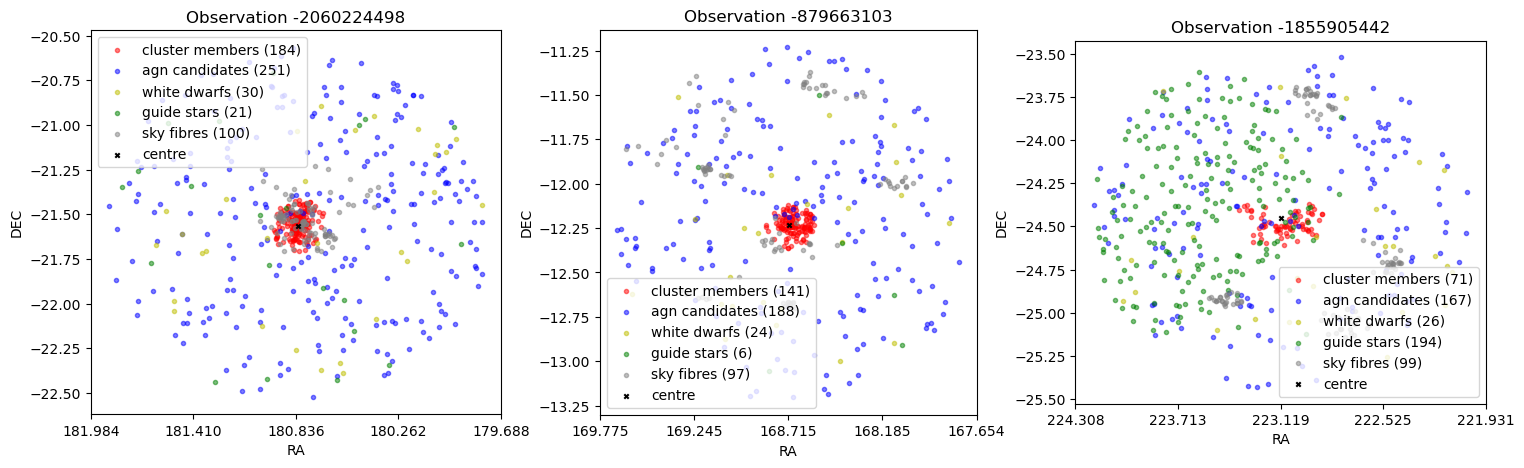

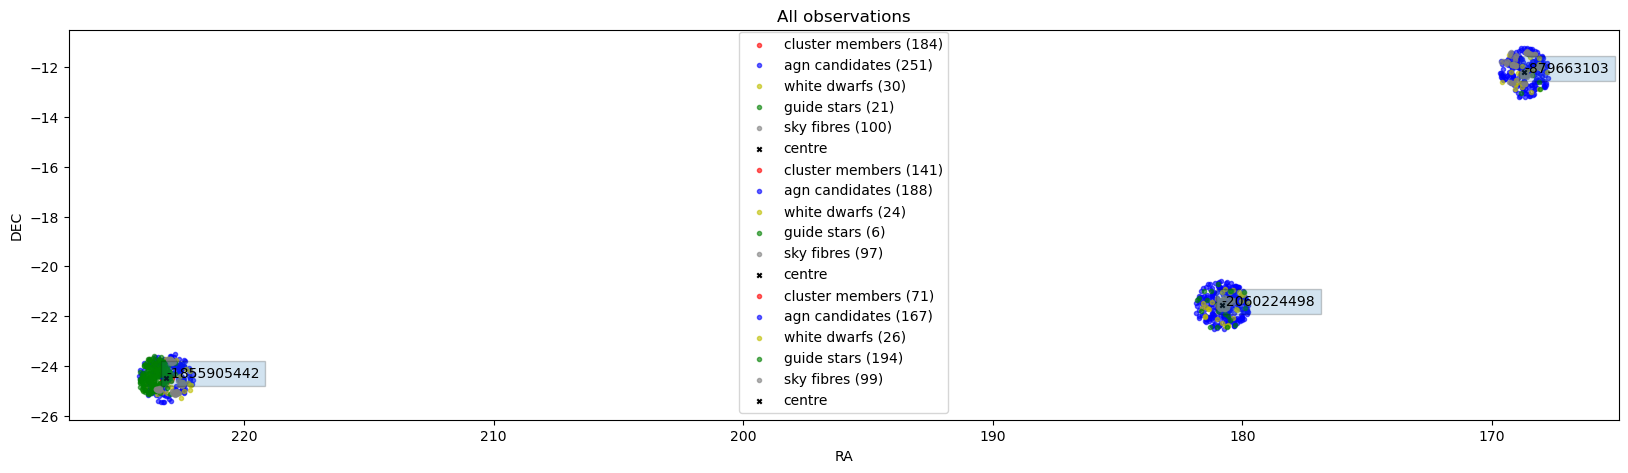

In [38]:
from matplotlib.ticker import LinearLocator
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, container in zip(axes, TARGET_CONTAINERS):
    container.plot_sources_on_ax(ax, alpha=0.5, marker=".")
    ax.xaxis.set_major_locator(LinearLocator(5))
    # ax.margins(-0.1)
fig, ax = plt.subplots(figsize=(20, 20))
for container in TARGET_CONTAINERS:
    container.plot_sources_on_ax(ax, alpha=0.6, marker=".")
    ax.set_title("All observations")
    ax.annotate(container.container_id, (container.obs_ra, container.obs_dec), bbox=dict(alpha=0.2))

## Alternative approach: Do the full run in one go:

The following cell performs the full run for each of the clusters:

[-2060224498] 184 science targets (cluster members) have been registered.
[-2060224498] 251 more science targets (AGN) have been registered.
[-2060224498] 10 white dwarfs have been registered.
[-2060224498] 150 guide stars have been registered.
[-2060224498] 150 sky fibres have been registered.


[-879663103] 141 science targets (cluster members) have been registered.
[-879663103] 188 more science targets (AGN) have been registered.
[-879663103] 10 white dwarfs have been registered.
[-879663103] 150 guide stars have been registered.
[-879663103] 150 sky fibres have been registered.


[-1855905442] 71 science targets (cluster members) have been registered.
[-1855905442] 167 more science targets (AGN) have been registered.
[-1855905442] 10 white dwarfs have been registered.
[-1855905442] 150 guide stars have been registered.
[-1855905442] 150 sky fibres have been registered.


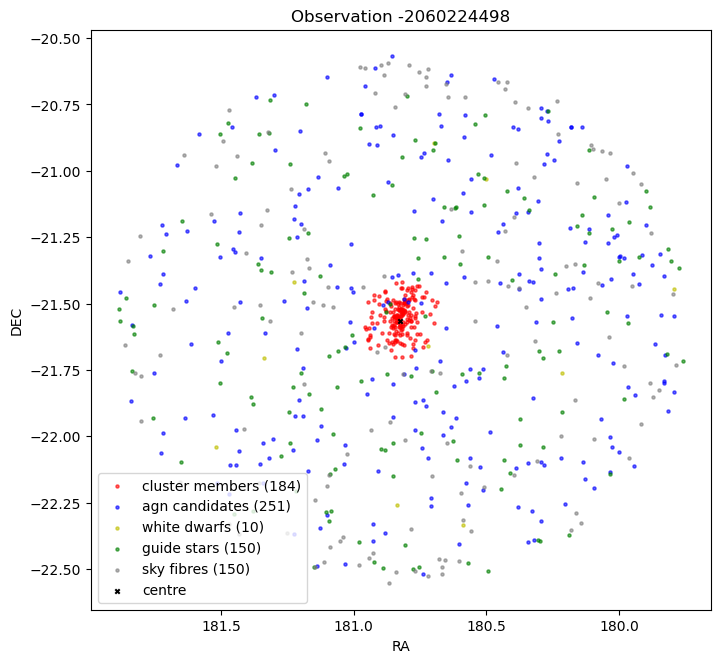

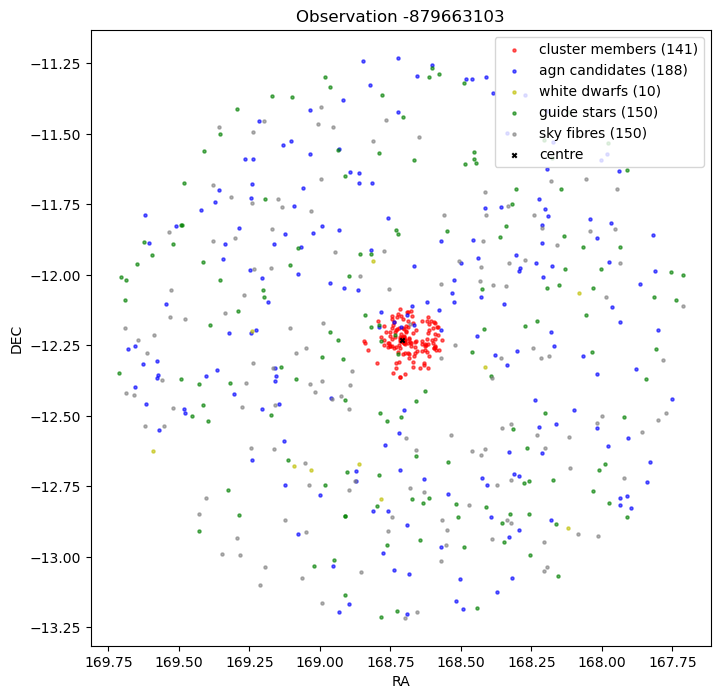

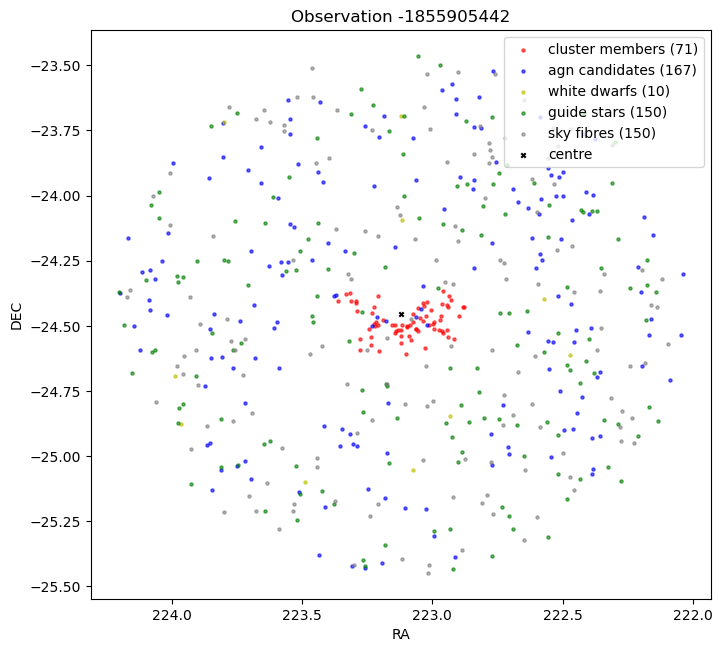

In [110]:
VERBOSE = False
GUIDE_R_MIN, GUIDE_R_MAX, GUIDE_PM_MAX = 14, 14.5, 50
for cluster in ALL_CLUSTERS:
    target_container = init_container_from_cluster(cluster)
    target_container.get_cluster_members(verbose=VERBOSE)
    target_container.get_agn(verbose=VERBOSE)
    target_container.get_white_dwarfs(verbose=VERBOSE)
    target_container.get_guide_stars(GUIDE_R_MIN, GUIDE_R_MAX, GUIDE_PM_MAX, verbose=VERBOSE)
    target_container.get_sky_fibres(verbose=VERBOSE)
    target_container.write_targets_to_disc()
    fig, ax = plt.subplots(figsize=(8, 8))
    target_container.plot_sources_on_ax(ax, alpha=0.6, marker=".", s=20)
    fig.savefig(f"./plots/positional_plot_{target_container.container_id}.png")

[-1855905442] 150 guide stars have been registered.


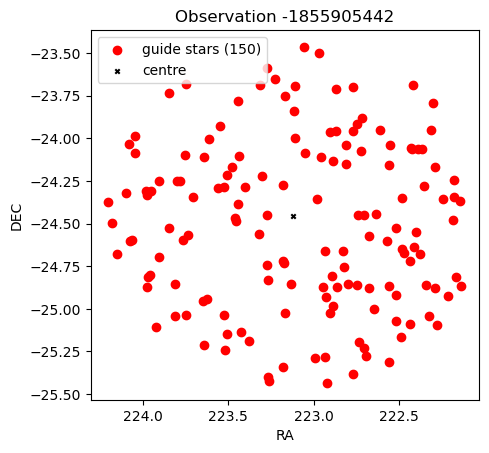

In [100]:
target_container.get_guide_stars(GUIDE_R_MIN, GUIDE_R_MAX, GUIDE_PM_MAX, verbose=VERBOSE)
fig, ax = plt.subplots()
target_container.plot_sources_on_ax(ax, types=["guide_stars"])

In [ ]:
for guide_star in target_container.guide_stars[:3]:
    url = acs.get_legacysurvey_url(guide_star["ra"], guide_star["dec"])
    print(url)
    acs.display_html_site(url)

https://www.legacysurvey.org/viewer?ra=222.8496573847596&dec=-25.248440346048312&layer=ls-dr10&zoom=14&mark=222.8496573847596,-25.248440346048312


/home/fbalzer/.opt/conda/envs/VERFU/lib/python3.9/site-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


https://www.legacysurvey.org/viewer?ra=222.93350729852418&dec=-25.280221261336358&layer=ls-dr10&zoom=14&mark=222.93350729852418,-25.280221261336358


https://www.legacysurvey.org/viewer?ra=222.94898125456282&dec=-25.245876790084374&layer=ls-dr10&zoom=14&mark=222.94898125456282,-25.245876790084374


## Find Sky fibres

In [71]:
target_container = TARGET_CONTAINERS[0]
radius = 1
ra, dec = target_container.obs_ra, target_container.obs_dec
region = acs.RectangularRegion.from_centre_and_radius(ra, dec, 1)
SWEEP = region.get_included_sweep_table()
SWEEP = acs.get_objects_in_circular_region(SWEEP, ra, dec, radius)
# SWEEP.colnames

In [81]:
import astropy.units as u
num_points = 15000
random_ra = np.random.uniform(ra -radius, ra + radius, num_points)
random_dec = np.random.uniform(dec - radius, dec + radius, num_points)
random_coords = SkyCoord(random_ra, random_dec, unit="deg")
sweep_coords = SkyCoord(SWEEP["ra"], SWEEP["dec"])
# Find all random coords far away from sweep sources
idx, d2d, _ = random_coords.match_to_catalog_sky(sweep_coords)
min_distance_to_others = 10 * u.arcsec
distant_sources = random_coords[d2d > min_distance_to_others]
# Find all random coords far away from themselves to prevent clustering:
idx, d2d, _ = distant_sources.match_to_catalog_sky(distant_sources, nthneighbor=2)
distant_sources = distant_sources[d2d > 4*min_distance_to_others]
distant_sources = Table([distant_sources.ra, distant_sources.dec], names=["ra", "dec"])
print(len(distant_sources))
distant_sources = acs.get_objects_in_circular_region(distant_sources, ra, dec, radius)
print(f"Found {len(distant_sources)} sky fibres")
for source in distant_sources[:3]:
    url = acs.get_legacysurvey_url(source["ra"], source["dec"])
    print(url)
    acs.display_html_site(url)

765
Found 224 sky fibres
https://www.legacysurvey.org/viewer?ra=180.8534637353822&dec=-20.5768871189433&layer=ls-dr10&zoom=14&mark=180.8534637353822,-20.5768871189433


https://www.legacysurvey.org/viewer?ra=180.62025483660344&dec=-20.612409259740677&layer=ls-dr10&zoom=14&mark=180.62025483660344,-20.612409259740677


https://www.legacysurvey.org/viewer?ra=181.76181011017573&dec=-21.48974306001826&layer=ls-dr10&zoom=14&mark=181.76181011017573,-21.48974306001826


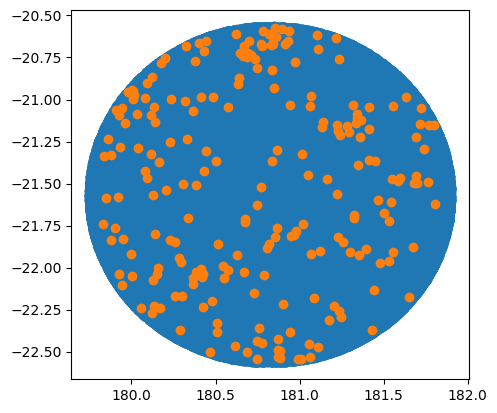

In [82]:

fig, ax = plt.subplots()
ax.scatter(SWEEP["ra"], SWEEP["dec"])
ax.scatter(distant_sources["ra"], distant_sources["dec"])
ax.set_aspect(True)

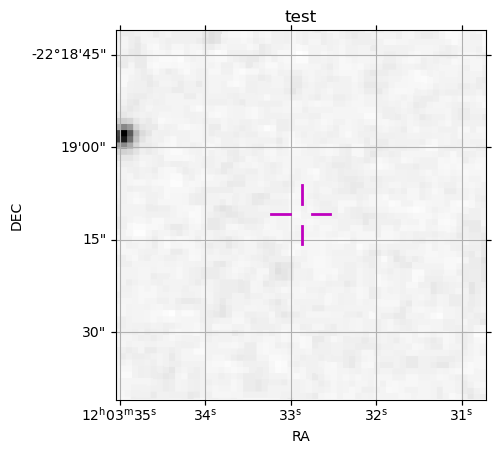

In [29]:
import astropy.units as u
import pylab as py
from astroplan import FixedTarget
from astroplan.plots import plot_finder_image
from astropy.coordinates import SkyCoord


ra, dec = 223.1186759011442, -24.453396496037488
ra, dec = target_container.obs_ra, target_container.obs_dec
for coord in distant_sources:
    target = FixedTarget(coord=coord, name="test")
    ax, hdu = plot_finder_image(
        target, survey='DSS2 Red', fov_radius=1.0 * u.arcmin, reticle=True)
#ax, hdu = plot_finder_image(target,survey='DSS',fov_radius=1.0*u.arcmin,reticle=True)
# print(tmp[0], n, ' of ', nlines)
# if (interactive):
#     yn = input('Is this sky good (Y/N)')

#     if ((yn == 'Y') | (yn == 'y')):
#         good.append(1)
#     else:
#         good.append(0)
def check_skies(infile, interactive=True):

    # read input file (in format from configure):
    lis = open(infile, 'r')
    lislines = lis.readlines()

    nlines = len(lislines)
    print('Number of lines in file: ', nlines)

    names = []
    good = []
    n = 0
    for line in lislines:

        py.clf()
        tmp = line.split()
        names.append('_'.join(tmp[2:3]))

        coordstr = ' '.join(tmp[4:10])
        print(coordstr)

        coord = SkyCoord(coordstr, unit=(u.hourangle, u.deg))
        target = FixedTarget(coord=coord, name=names[n])
        print(coord)
        print(target)
        ax, hdu = plot_finder_image(
            target, survey='DSS2 Red', fov_radius=1.0 * u.arcmin, reticle=True)
        #ax, hdu = plot_finder_image(target,survey='DSS',fov_radius=1.0*u.arcmin,reticle=True)
        py.show()
        print(tmp[0], n, ' of ', nlines)
        if (interactive):
            yn = input('Is this sky good (Y/N)')

            if ((yn == 'Y') | (yn == 'y')):
                good.append(1)
            else:
                good.append(0)

        n = n + 1

    if (interactive):
        print('all skies:')
        print(len(names), len(good), n)
        for i in range(n):
            print(names[i], good[i])

        print('bad skies:')
        for i in range(n):
            if (good[i] == 0):
                print(names[i], good[i])

## Check Gaia sources

In [57]:
import astropy.units as u

from astropy.coordinates import SkyCoord

from astroquery.gaia import Gaia


ra, dec = target_container.obs_ra, target_container.obs_dec
coord = SkyCoord(ra, dec, unit="deg")
from astroquery.gaia import Gaia

gaiadr3_table = Gaia.load_table('gaiadr3.gaia_source')

# print(gaiadr3_table)
# print("\n".join([col.name for col in gaiadr3_table.columns]))
job = Gaia.launch_job(f"""
select source_id, ra, dec, ref_epoch, pmra, pmdec, phot_rp_mean_mag 

from gaiadr3.gaia_source 
                      
where phot_rp_mean_mag < 15 and phot_rp_mean_mag > 14
    and ra < {ra + 1} and ra > {ra - 1} and dec < {dec + 1} and dec > {dec -1}
""")

r = job.get_results()
# job = Gaia.launch_job("select top 100 "

#                       "source_id, ra, dec, ref_epoch, pmra, pmdec, phot_rp_mean_mag "

#                       "from gaiadr3.gaia_source where phot_rp_mean_mag < 15 and phot_rp_mean_mag > 14")

# r = job.get_results()

print(r)


Retrieving table 'gaiadr3.gaia_source'
     source_id              ra         ...        pmdec         phot_rp_mean_mag
                           deg         ...       mas / yr             mag       
------------------- ------------------ ... -------------------- ----------------
6230248640109817088 222.12198700974722 ...  -0.6096435458538044        14.981949
6230277261771918848 222.12350985357847 ...   1.7367166043045712         14.51173
6228934861153636864 222.12612486663136 ...    9.637317221716449        14.617101
6230201292390332928 222.12749156444008 ...   2.1300976631403676        14.438021
6230201292390333184 222.12753538339905 ...   -5.902368884160099        14.439883
6229026773453872000 222.12760954513485 ...  -0.7885226032196092        14.637736
6229791724309191296 222.12908351143201 ...   -6.316728581434376        14.583687
6230175110269889408 222.13066087099153 ...  -10.841476231884759        14.501156
6230278120765391360  222.1315785418068 ...  -15.195323647744639       

In [67]:
SWEEP["pmtot"] = acs.calc_pm_tot(SWEEP["pmra"], SWEEP["pmdec"])
mask = (SWEEP["gaia_phot_rp_mean_mag"] > 14) & (SWEEP["gaia_phot_rp_mean_mag"] < 14.5)
mask &= SWEEP["type"] == "PSF"
mask &= SWEEP["pmtot"] < 50
SWEEP[["ra", "dec", "pmra", "pmdec", "gaia_phot_rp_mean_mag", "ref_id"]][mask][:100]
# SWEEP.colnames

ra,dec,pmra,pmdec,gaia_phot_rp_mean_mag,ref_id
deg,deg,mas / yr,mas / yr,mag,
float64,float64,float32,float32,float32,int64
179.89941710242454,-21.076314277993713,32.479355,-24.716074,14.000716,3494356190544894464
179.798071460749,-21.387403428115473,3.3915615,-12.505709,14.304387,3494314615261453056
179.96616926926114,-21.57459806538718,-31.981277,-7.2398624,14.194541,3494258746326916224
179.97136115879093,-21.61883823662267,-5.532139,2.7726598,14.448316,3494258059132146560
179.98389015582487,-21.38537391000734,5.2464266,-4.8909926,14.435553,3494312450597995520
179.77395797265842,-21.36780056435894,-9.32001,5.415125,14.209783,3494314890139360256
179.80512410579573,-21.340999731921503,-15.874474,-3.0886257,14.210803,3494316436327588352
179.814904682937,-21.293912381688305,-24.714878,13.061083,14.069715,3494317398400264320
